# RNN for time series forecasting

This notebook is based on book: [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python).

Here we will use Keras to build RNN which will be used to forecast air temperature 24 hours in the future.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4

import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


# Load data

Data is taken from Weather Station at the Max Planc Insitute for Biogeochemistry in Jena, Germany.

This data is recorded for every 10 minutes and goes back to 2003. But here we will use limited data from 2009-2016.

This data can be downloaded from: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [2]:
data_frame = pd.read_csv('../../datasets/jena_climate_2009_2016.csv')
input_data = data_frame.values[:, 1:].astype(float)
data_frame.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### We are interested in temperature

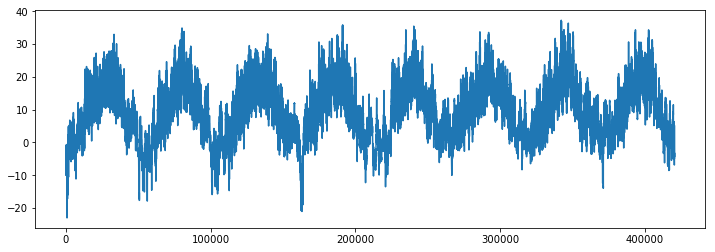

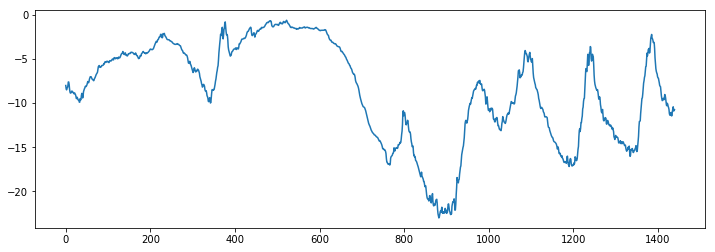

In [3]:
temperature = input_data[:, 1]
plt.plot(temperature)
plt.show()
# First 10 days
plt.plot(temperature[:1440])
plt.show()

# Preparing the data

## Normalize data

Since we have different time series, we need to normalize them so they will have similar scale

In [4]:
TRAINING_SIZE = 200000
mean = input_data[:TRAINING_SIZE].mean(axis=0)
stddev = input_data[:TRAINING_SIZE].std(axis=0)
normalized_data = (input_data - mean) / stddev
print(normalized_data)

[[ 0.90014748 -1.93135845 -1.98211036 ..., -0.72950452 -0.78067973
  -0.27613603]
 [ 0.9060434  -1.97541381 -2.02567    ..., -0.93124017 -0.88794488
  -0.46317443]
 [ 0.90132666 -1.98671006 -2.03683914 ..., -1.27614304 -1.26122763
  -0.05330633]
 ..., 
 [ 1.28927851 -1.38236094 -1.46721307 ..., -0.69696652 -0.67341457
   0.45008097]
 [ 1.28809932 -1.50323076 -1.58672285 ..., -0.43015486 -0.60476487
   0.57246412]
 [ 1.28927851 -1.56987861 -1.65150386 ..., -0.5993525  -0.690577
   0.10024989]]


## Data generator

Because the samples in the dataset are highly reduntant, we will use dataset generator for splitting data into separate train, test and validation set.

In [5]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """
    Params:
    data - normalized input data
    lookback - how many timesteps back the input data should go
    delay - How many timesteps in the future the target should be
    min_index, max_index - data indices
    shuffle - randomize data?
    batch_size - #samples in the batch
    step - The period of data sampling (6 = every hour)
    """
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index+lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i+batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

next(generator(normalized_data, 2, 0, 0, 10, shuffle=False, batch_size=1, step=1))

(array([[[ 0.90014748, -1.93135845, -1.98211036, -1.86280029,  1.07285236,
          -1.30742164, -1.47375773, -0.79868641, -1.4762674 , -1.47815522,
           2.12375056, -0.72950452, -0.78067973, -0.27613603],
         [ 0.9060434 , -1.97541381, -2.02567   , -1.91582958,  1.07883061,
          -1.32042698, -1.4951961 , -0.80075238, -1.49502455, -1.49932141,
           2.17199852, -0.93124017, -0.88794488, -0.46317443]]]),
 array([-1.98671006]))

In [6]:
lookback = 1440  # Use data from the last 10 days
step = 6         # Observations will be sampled at one data point per hour
delay = 144      # Targets will be 24 hours in the future
batch_size = 128 

train_gen = generator(normalized_data, lookback=lookback, delay=delay, min_index=0, max_index=TRAINING_SIZE, 
                      shuffle=True, batch_size=batch_size, step=step)

val_gen = generator(normalized_data, lookback=lookback, delay=delay, min_index=TRAINING_SIZE, max_index=300000, 
                    shuffle=True, batch_size=batch_size, step=step)

test_gen = generator(normalized_data, lookback=lookback, delay=delay, min_index=300001, max_index=None,
                     shuffle=True, batch_size=batch_size, step=step)

val_steps = 300000 - 200001 - lookback
test_steps = len(normalized_data) - 300001 - lookback

# Common-sense baseline

Based on intuition we will predict that that the temperature will be the same like in the last somple in feature vector.

In [16]:
def evaluate_naive_method():
    batch_meas = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_meas.append(mae)
    print(np.mean(batch_meas))
    
start_time = time.time()    
evaluate_naive_method()    
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

0.28963222445
Calculated in 660.725 seconds


# Basic ML model

Before starting using RNN, lets build model using small densely connected networks. For this will will flat our

```
(batch_size, lookback // step, #features)
```

tensor into
```
(batch_size, lookback // step * #features)
```

In [7]:
start_time = time.time()
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, normalized_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=1000)
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
500/500 [==============================] - 38s 76ms/step - loss: 1.2460 - val_loss: 0.5262
Epoch 2/20
500/500 [==============================] - 36s 73ms/step - loss: 0.4487 - val_loss: 0.3829
Epoch 3/20
500/500 [==============================] - 38s 76ms/step - loss: 0.2950 - val_loss: 0.3123
Epoch 4/20
500/500 [==============================] - 40s 81ms/step - loss: 0.2702 - val_loss: 0.3031
Epoch 5/20
500/500 [==============================] - 46s 93ms/step - loss: 0.2561 - val_loss: 0.3295
Epoch 6/20
500/500 [==============================] - 45s 90ms/step - loss: 0.2441 - val_loss: 0.3256
Epoch 7/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2359 - val_loss: 0.3201
Epoch 8/20
500/500 [==============================] - 46s 92ms/step - loss: 0.2303 - val_loss: 0.3676
Epoch 9/20
500/500 [==================

## Ploting results

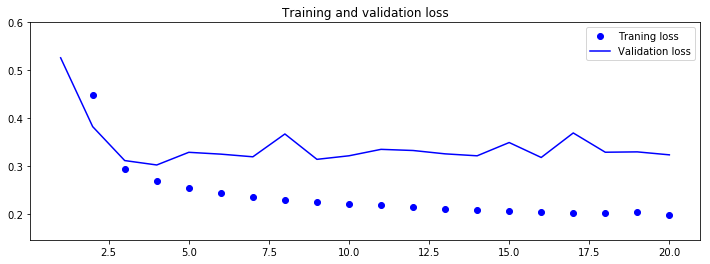

In [8]:
def plot_loss(hist):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Traning loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.ylim(ymax=0.6)
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    
plot_loss(history)

# RNN baseline

Lets now try RNN which should be more suited to this problem. For this network we will use GRU layers which are cheaper to compute then more powerful LSTM

In [ ]:
start_time = time.time()
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, normalized_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, 
                              validation_data=val_gen, validation_steps=1000)
print("Calculated in {:.3f} seconds".format(time.time() - start_time))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
500/500 [==============================] - 331s 662ms/step - loss: 0.3068 - val_loss: 0.2715
Epoch 2/20
500/500 [==============================] - 323s 646ms/step - loss: 0.2851 - val_loss: 0.2671
Epoch 3/20
500/500 [==============================] - 344s 689ms/step - loss: 0.2784 - val_loss: 0.2659
Epoch 4/20
500/500 [==============================] - 382s 765ms/step - loss: 0.2738 - val_loss: 0.2606
Epoch 5/20
500/500 [==============================] - 452s 905ms/step - loss: 0.2676 - val_loss: 0.2689
Epoch 6/20
500/500 [==============================] - 439s 877ms/step - loss: 0.2639 - val_loss: 0.2652
Epoch 7/20
330/500 [==================>...........] - ETA: 1:44 - loss: 0.2615